In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
import time
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import mlflow
import mlflow.statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)

# Data Ingestion

In [2]:
cameraAcc_final = pd.read_csv("Modelling_Data/cameraAcc_final2.csv")
gamingAcc_final = pd.read_csv("Modelling_Data/gamingAcc_final2.csv")
homeAudio_final = pd.read_csv("Modelling_Data/homeAudio_final2.csv")

# Modelling for Camera

In [3]:
df = cameraAcc_final.copy()
df.head(5)

,order_week,Month,Year,adStock_Traditional Marketing,adStock_Digital Marketing,adStock_Partnership Marketing,adStock_Other Marketing,gmv,units,sla,...,CameraTripod,ExtensionTube,Filter,Flash,FlashShoeAdapter,Lens,ReflectorUmbrella,Softbox,Strap,Telescope
0,27,7,2015,2.8611,3.3318,2.9856,0.0000,15375.0000,25,2.2800,...,13,0,0,0,0,2,0,0,0,0
1,28,7,2015,3.3379,3.8872,3.4832,0.0000,2019042.0000,2752,7.1563,...,433,0,226,17,0,366,0,0,13,16
2,29,7,2015,3.5764,4.1648,3.7320,0.0000,2249245.0000,2917,6.4913,...,491,0,188,23,0,382,0,0,24,22
3,30,7,2015,3.6956,4.3036,3.8564,0.0000,2105858.0000,2888,6.4881,...,457,0,194,18,0,423,0,0,23,30
4,31,7,2015,3.7552,4.3730,3.9186,0.0000,1426134.0000,1932,6.4707,...,363,0,112,26,0,233,0,0,23,13


In [4]:
df.columns

Index(['order_week', 'Month', 'Year', 'adStock_Traditional Marketing',
       'adStock_Digital Marketing', 'adStock_Partnership Marketing',
       'adStock_Other Marketing', 'gmv', 'units', 'sla',
       'product_procurement_sla', 'product_mrp', 'selling_price', 'NPS',
       'discount', 'total_transactions', 'total_premium_products',
       'total_holidays', 'is_holiday', 'total_special_sale_days',
       'is_special_sale_day', 'total_pay_days', 'is_pay_day', 'Binoculars',
       'CameraAccessory', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger',
       'CameraBatteryGrip', 'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing',
       'CameraMicrophone', 'CameraMount', 'CameraRemoteControl',
       'CameraTripod', 'ExtensionTube', 'Filter', 'Flash', 'FlashShoeAdapter',
       'Lens', 'ReflectorUmbrella', 'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [5]:
# Drop non-controllable variables
df_model = df.drop(['selling_price', 'units', 'product_mrp', 'total_transactions', 'order_week', 'is_holiday', 'is_special_sale_day', 'is_pay_day', 'Month', 'Year'], axis=1)
df_model.columns

Index(['adStock_Traditional Marketing', 'adStock_Digital Marketing',
       'adStock_Partnership Marketing', 'adStock_Other Marketing', 'gmv',
       'sla', 'product_procurement_sla', 'NPS', 'discount',
       'total_premium_products', 'total_holidays', 'total_special_sale_days',
       'total_pay_days', 'Binoculars', 'CameraAccessory', 'CameraBag',
       'CameraBattery', 'CameraBatteryCharger', 'CameraBatteryGrip',
       'CameraEyeCup', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone',
       'CameraMount', 'CameraRemoteControl', 'CameraTripod', 'ExtensionTube',
       'Filter', 'Flash', 'FlashShoeAdapter', 'Lens', 'ReflectorUmbrella',
       'Softbox', 'Strap', 'Telescope'],
      dtype='object')

In [6]:
df_model.shape

(52, 35)

### Train-Test Split

In [7]:
df_train, df_test = train_test_split(df_model, train_size=0.8, test_size=0.2, random_state=100)

# Separate target variable
y_train = df_train.pop('gmv')
X_train = df_train
y_test = df_test.pop('gmv')
X_test = df_test

### Scaling

In [8]:
# List of numerical columns (excluding categorical)
num_cols = X_train.select_dtypes(include=['number']).columns

# Scaling
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### Feature Elimination using RFE

In [9]:
def perform_rfe(X_train, y_train, num_features=20):
    """
    Uses Recursive Feature Elimination (RFE) with Linear Regression 
    to select the top 'num_features'.
    """
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=num_features)  # Fixed argument issue
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    print(f"Selected Features ({num_features}): {list(selected_features)}")

    return X_train[selected_features], selected_features

In [10]:
# Run RFE
X_train_rfe, selected_features = perform_rfe(X_train, y_train, num_features=20)
X_test_rfe = X_test[selected_features]  

Selected Features (20): ['adStock_Traditional Marketing', 'adStock_Digital Marketing', 'adStock_Partnership Marketing', 'sla', 'NPS', 'discount', 'total_premium_products', 'Binoculars', 'CameraBag', 'CameraBattery', 'CameraBatteryCharger', 'CameraFilmRolls', 'CameraHousing', 'CameraMicrophone', 'CameraMount', 'CameraTripod', 'Filter', 'Flash', 'Lens', 'Strap']


### Model Training Function

In [11]:
def train_initial_model(X_train, y_train):
    """Builds and logs the initial OLS model before feature elimination starts."""
    mlflow.set_experiment("MMM_Modeling")

    with mlflow.start_run():
        print("\nBuilding Initial Model...")

        # Add constant for OLS
        X_train_lm = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train_lm).fit()

        # Print Model Summary
        print(model.summary())

        # Compute VIF values
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_train.columns
        vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        vif_data = vif_data.sort_values(by="VIF", ascending=False)

        print("\nInitial VIF Values:")
        print(vif_data)

        # Log model details to MLflow
        mlflow.log_param("Initial Features", list(X_train.columns))
        mlflow.log_metric("Initial R-squared", model.rsquared)
        mlflow.sklearn.log_model(model, "Initial_Model")

    return model, X_train

In [12]:
# Step 2: Build the initial model after RFE
initial_model, X_train_final = train_initial_model(X_train_rfe, y_train)


Building Initial Model...
                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     142.5
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           2.36e-17
Time:                        00:43:44   Log-Likelihood:                -523.19
No. Observations:                  41   AIC:                             1088.
Df Residuals:                      20   BIC:                             1124.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

2025/03/16 00:43:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [13]:
def train_optimized_model(X_train, y_train, X_test, y_test, max_iterations=10, vif_threshold=100, p_value_threshold=0.05):
    """
    Step 1: Eliminates features based on VIF until all values are ≤ 100.
    Step 2: Builds the model and iteratively removes high p-value features.
    Logs each iteration to MLflow.
    """
    mlflow.set_experiment("MMM_Modeling")

    # Ensure previous MLflow runs are properly closed
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run():
        eliminated_features = []
        
        ### **Step 1: Remove High VIF Features Before Modeling**
        print("\n========== Eliminating High VIF Features Before Modeling ==========")
        while True:
            # Compute VIF
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_train.columns
            vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
            vif_data = vif_data.sort_values(by="VIF", ascending=False)

            print(f"\nVIF Before Modeling:")
            print(vif_data)

            # Check if the highest VIF is still above the threshold
            if vif_data["VIF"].max() > vif_threshold:
                high_vif_feature = vif_data.iloc[0]["Feature"]
                print(f"Removing {high_vif_feature} due to very high VIF ({vif_data.iloc[0]['VIF']:.2f})")
                X_train = X_train.drop(columns=[high_vif_feature])
                eliminated_features.append(high_vif_feature)
            else:
                print("All VIF values are now below the threshold. Proceeding to modeling.")
                break  # Stop when all VIF values are ≤ threshold

        ### **Step 2: Start Modeling and Eliminate High p-value Features**
        iteration = 1
        while iteration <= max_iterations:
            print(f"\n========== Iteration {iteration}: Training Model ==========")

            # Fit OLS Model
            X_train_lm = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train_lm).fit()

            # Print Model Summary
            print(f"\nModel Summary (Iteration {iteration}):")
            print(model.summary())

            # Compute VIF
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_train.columns
            vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
            vif_data = vif_data.sort_values(by="VIF", ascending=False)

            print(f"\nVIF Values (Iteration {iteration}):")
            print(vif_data)

            feature_removed = False  # Track if any feature was removed

            # **Step 2: Eliminate the Highest p-value Feature**
            p_values = model.pvalues.drop("const", errors="ignore")
            max_p_feature = p_values.idxmax()
            max_p_value = p_values.max()

            if max_p_value > p_value_threshold:
                if max_p_feature in X_train.columns:
                    print(f"Removing {max_p_feature} due to high p-value ({max_p_value:.4f})")
                    X_train = X_train.drop(columns=[max_p_feature])
                    eliminated_features.append(max_p_feature)
                    feature_removed = True
                else:
                    print(f"Skipping {max_p_feature}, as it's not in X_train.")
            else:
                print("No high p-value features remaining.")

            # **If no features were removed, stop the process**
            if not feature_removed:
                print("\nNo more features to remove. Stopping.")
                break

            iteration += 1

        # Final Model
        final_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        print(f"\n========== Final Model Summary ==========")
        print(final_model.summary())

        # Print final VIF values
        final_vif_data = pd.DataFrame()
        final_vif_data["Feature"] = X_train.columns
        final_vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        final_vif_data = final_vif_data.sort_values(by="VIF", ascending=False)

        print(f"\n========== Final VIF Values ==========")
        print(final_vif_data)

        # Ensure X_test matches selected features in X_train
        X_test_final = X_test[X_train.columns]
        X_test_final = sm.add_constant(X_test_final)

        # Predictions
        y_test_pred = final_model.predict(X_test_final)
        r2 = r2_score(y_test, y_test_pred)

        # Log to MLflow
        mlflow.log_param("Eliminated Features", eliminated_features)
        mlflow.log_metric("Final R-squared", r2)
        mlflow.sklearn.log_model(final_model, "Final_Model")

        # Ensure MLflow run is properly closed
        mlflow.end_run()

        return final_model, X_train
def train_optimized_model(X_train, y_train, X_test, y_test, max_iterations=10, vif_threshold=100, p_value_threshold=0.05):
    """
    Step 1: Eliminates features based on VIF until all values are ≤ 100.
    Step 2: Builds the model and iteratively removes high p-value features.
    Logs each iteration to MLflow.
    """
    mlflow.set_experiment("MMM_Modeling")

    # Ensure previous MLflow runs are properly closed
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run():
        eliminated_features = []
        
        ### **Step 1: Remove High VIF Features Before Modeling**
        print("\n========== Eliminating High VIF Features Before Modeling ==========")
        while True:
            # Compute VIF
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_train.columns
            vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
            vif_data = vif_data.sort_values(by="VIF", ascending=False)

            print(f"\nVIF Before Modeling:")
            print(vif_data)

            # Check if the highest VIF is still above the threshold
            if vif_data["VIF"].max() > vif_threshold:
                high_vif_feature = vif_data.iloc[0]["Feature"]
                print(f"Removing {high_vif_feature} due to very high VIF ({vif_data.iloc[0]['VIF']:.2f})")
                X_train = X_train.drop(columns=[high_vif_feature])
                eliminated_features.append(high_vif_feature)
            else:
                print("All VIF values are now below the threshold. Proceeding to modeling.")
                break  # Stop when all VIF values are ≤ threshold

        ### **Step 2: Start Modeling and Eliminate High p-value Features**
        iteration = 1
        while iteration <= max_iterations:
            print(f"\n========== Iteration {iteration}: Training Model ==========")

            # Fit OLS Model
            X_train_lm = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train_lm).fit()

            # Print Model Summary
            print(f"\nModel Summary (Iteration {iteration}):")
            print(model.summary())

            # Compute VIF
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_train.columns
            vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
            vif_data = vif_data.sort_values(by="VIF", ascending=False)

            print(f"\nVIF Values (Iteration {iteration}):")
            print(vif_data)

            feature_removed = False  # Track if any feature was removed

            # **Step 2: Eliminate the Highest p-value Feature**
            p_values = model.pvalues.drop("const", errors="ignore")
            max_p_feature = p_values.idxmax()
            max_p_value = p_values.max()

            if max_p_value > p_value_threshold:
                if max_p_feature in X_train.columns:
                    print(f"Removing {max_p_feature} due to high p-value ({max_p_value:.4f})")
                    X_train = X_train.drop(columns=[max_p_feature])
                    eliminated_features.append(max_p_feature)
                    feature_removed = True
                else:
                    print(f"Skipping {max_p_feature}, as it's not in X_train.")
            else:
                print("No high p-value features remaining.")

            # **If no features were removed, stop the process**
            if not feature_removed:
                print("\nNo more features to remove. Stopping.")
                break

            iteration += 1

        # Final Model
        final_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
        print(f"\n========== Final Model Summary ==========")
        print(final_model.summary())

        # Print final VIF values
        final_vif_data = pd.DataFrame()
        final_vif_data["Feature"] = X_train.columns
        final_vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        final_vif_data = final_vif_data.sort_values(by="VIF", ascending=False)

        print(f"\n========== Final VIF Values ==========")
        print(final_vif_data)

        # Ensure X_test matches selected features in X_train
        X_test_final = X_test[X_train.columns]
        X_test_final = sm.add_constant(X_test_final)

        # Predictions
        y_test_pred = final_model.predict(X_test_final)
        r2 = r2_score(y_test, y_test_pred)

        # Log to MLflow
        mlflow.log_param("Eliminated Features", eliminated_features)
        mlflow.log_metric("Final R-squared", r2)
        mlflow.sklearn.log_model(final_model, "Final_Model")

        # Ensure MLflow run is properly closed
        mlflow.end_run()

        return final_model, X_train


In [14]:
final_model, X_train_final = train_optimized_model(X_train_final, y_train, X_test_rfe, y_test, max_iterations=10, vif_threshold=100)


========== Eliminating High VIF Features Before Modeling ==========

VIF Before Modeling:
                          Feature        VIF
6          total_premium_products 77980.7649
17                          Flash  4881.6261
15                   CameraTripod  2468.1656
9                   CameraBattery  2294.5330
2   adStock_Partnership Marketing  2085.2940
0   adStock_Traditional Marketing  1837.8341
18                           Lens  1124.9836
10           CameraBatteryCharger   758.0192
8                       CameraBag   655.9258
16                         Filter   574.7673
7                      Binoculars   457.8084
19                          Strap    61.2523
5                        discount    60.3434
11                CameraFilmRolls    45.8830
3                             sla    36.8500
14                    CameraMount    28.8552
1       adStock_Digital Marketing    21.7199
4                             NPS    19.0547
13               CameraMicrophone     8.7842
12       

2025/03/16 00:43:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Model Performance on Test Data

In [15]:
def evaluate_model(model, X, y, dataset_name="Test"):
    """
    Evaluates model performance on given dataset (Train/Test) using R², MAE, MSE, and RMSE.
    Also logs results to MLflow for tracking.
    """
    # Ensure X contains the same features as the trained model
    X_final = X[model.model.exog_names[1:]]  # Exclude 'const'
    X_final = sm.add_constant(X_final)

    # Make Predictions
    y_pred = model.predict(X_final)

    # Compute Evaluation Metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    # Print Results
    print(f"\nModel Performance on {dataset_name} Data:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # Log to MLflow
    mlflow.log_metric(f"{dataset_name} R-squared", r2)
    mlflow.log_metric(f"{dataset_name} MAE", mae)
    mlflow.log_metric(f"{dataset_name} MSE", mse)
    mlflow.log_metric(f"{dataset_name} RMSE", rmse)

    return y_pred

In [16]:
# Evaluate model performance on TRAIN data
y_train_pred = evaluate_model(final_model, X_train_final, y_train, dataset_name="Train")

# Evaluate model performance on TEST data
y_test_pred = evaluate_model(final_model, X_test_rfe, y_test, dataset_name="Test")


Model Performance on Train Data:
R² Score: 0.9848
MAE: 99305.87
MSE: 15474388579.24
RMSE: 124396.10

Model Performance on Test Data:
R² Score: 0.9003
MAE: 212823.04
MSE: 152294886235.40
RMSE: 390249.77


In [17]:
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_test_pred):
    """
    Plots actual GMV vs predicted GMV to visually analyze model performance.
    """
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.xlabel("Actual GMV")
    plt.ylabel("Predicted GMV")
    plt.title("Actual vs Predicted GMV")
    plt.axline((0,0), slope=1, color="red", linestyle="dashed")  # Ideal Prediction Line
    plt.show()

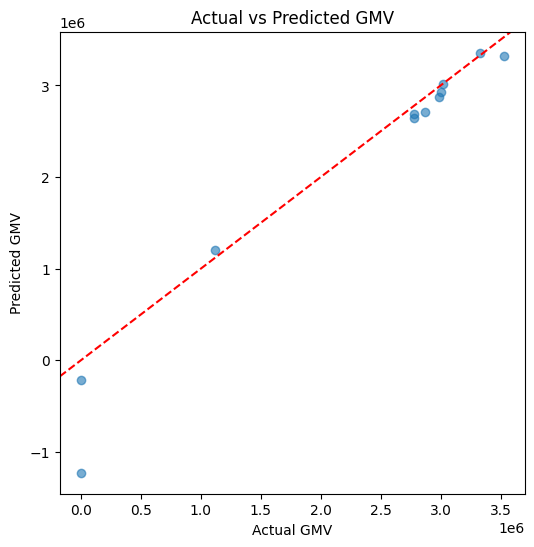

In [18]:
# Step 2: Visualize Predictions
plot_predictions(y_test, y_test_pred)

In [19]:
def plot_residuals(y_test, y_test_pred):
    """
    Plots residuals (errors) to check model stability.
    """
    residuals = y_test - y_test_pred

    plt.figure(figsize=(6,4))
    plt.scatter(y_test_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="dashed")
    plt.xlabel("Predicted GMV")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()

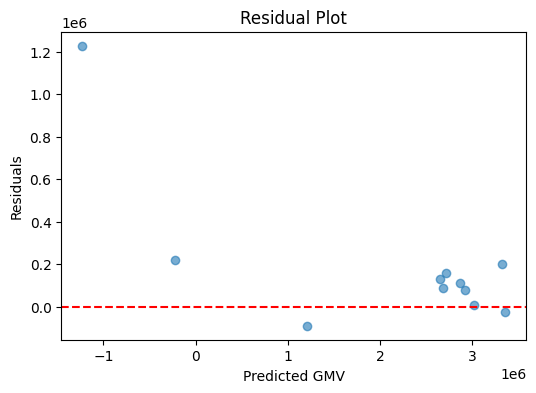

In [20]:
# Step 3: Check Residuals for Model Stability
plot_residuals(y_test, y_test_pred)

### Business Interpretation - Elasticity

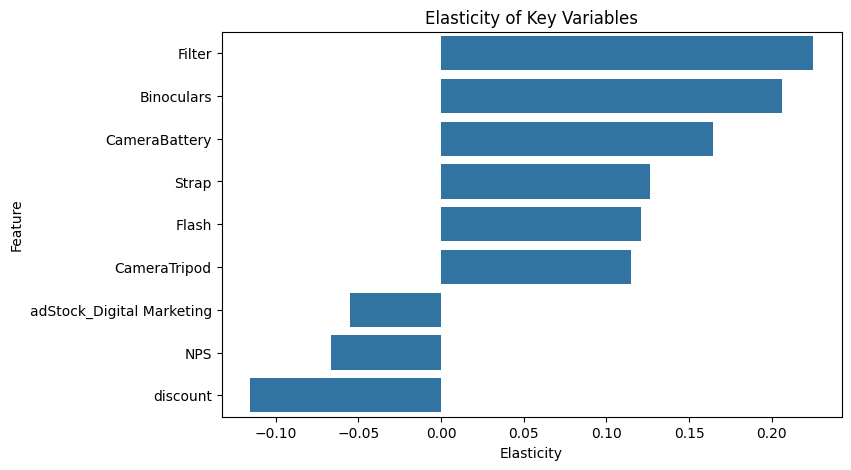

In [21]:
def get_elasticity(X_train, y_train, model):
    """
    Computes elasticity only for features that exist in the final model.
    Ensures consistent array lengths to prevent ValueErrors.
    """
    elasticity = {}
    valid_features = model.params.index.tolist()  # Get features in final model

    for feature in X_train.columns:
        if feature in valid_features:  # Check if feature exists in model params
            feature_mean = X_train[feature].mean()
            coef = model.params[feature]
            elasticity[feature] = (coef * feature_mean) / y_train.mean()

    # Convert to DataFrame
    elasticity_df = pd.DataFrame(list(elasticity.items()), columns=["Feature", "Elasticity"])
    
    return elasticity_df

# Compute Elasticity (Fixed Version)
elasticity_df = get_elasticity(X_train_final, y_train, final_model)

# Plot Elasticity
plt.figure(figsize=(8,5))
sns.barplot(y="Feature", x="Elasticity", data=elasticity_df.sort_values("Elasticity", ascending=False))
plt.xlabel("Elasticity")
plt.ylabel("Feature")
plt.title("Elasticity of Key Variables")
plt.show()


### Ridge Regularization

In [23]:
# Ensure X_test_rfe contains only the features that were used in training
X_test_ridge = X_test_rfe[X_train_final.columns]

In [25]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train Ridge model using the final selected features
ridge_model = Ridge(alpha=10)  # Try different alpha values if needed
ridge_model.fit(X_train_final, y_train)

# Ensure X_test contains the same features as X_train_final
X_test_ridge = X_test_rfe[X_train_final.columns]

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_final)
y_test_pred_ridge = ridge_model.predict(X_test_ridge)

# Evaluate Ridge Performance
print("\n========== Ridge Regression Performance ==========")
print("Train R²:", r2_score(y_train, y_train_pred_ridge))
print("Test R²:", r2_score(y_test, y_test_pred_ridge))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred_ridge))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_ridge))



========== Ridge Regression Performance ==========
Train R²: 0.5954247970173309
Test R²: 0.5274490292602387
Train RMSE: 642016.0649703362
Test RMSE: 849792.3155907899
Train MAE: 367880.93763846625
Test MAE: 607655.1113139245


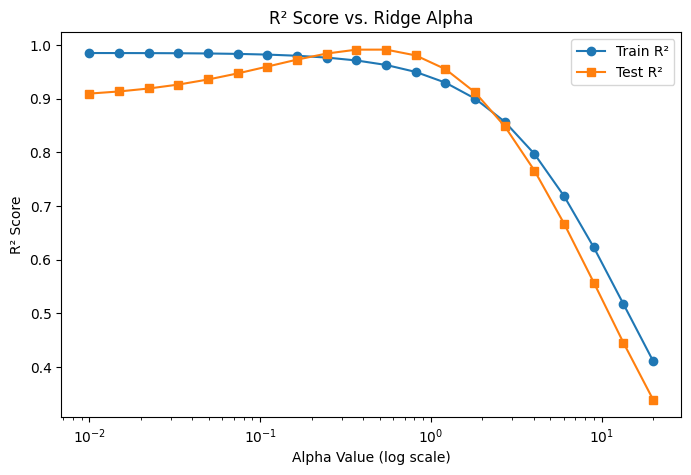

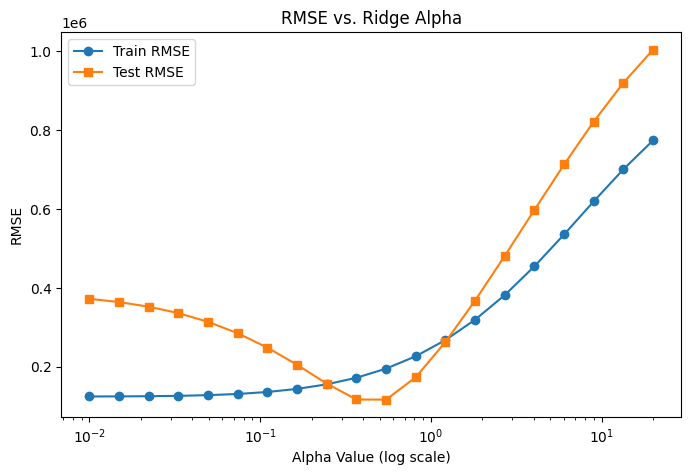

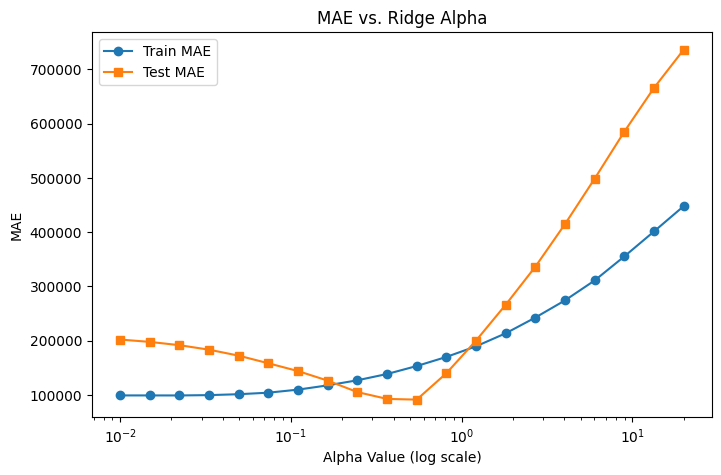

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define alpha values to test
alpha_values = np.logspace(np.log10(0.01), np.log10(20), 20)
alpha_values

# Store results
train_r2, test_r2 = [], []
train_rmse, test_rmse = [], []
train_mae, test_mae = [], []

# Loop through each alpha value and train Ridge model
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_final, y_train)
    y_train_pred = ridge_model.predict(X_train_final)
    y_test_pred = ridge_model.predict(X_test_ridge)

    # Store metrics
    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))

# Plot R² Scores
plt.figure(figsize=(8,5))
plt.plot(alpha_values, train_r2, marker='o', label="Train R²")
plt.plot(alpha_values, test_r2, marker='s', label="Test R²")
plt.xscale("log")
plt.xlabel("Alpha Value (log scale)")
plt.ylabel("R² Score")
plt.title("R² Score vs. Ridge Alpha")
plt.legend()
plt.show()

# Plot RMSE Scores
plt.figure(figsize=(8,5))
plt.plot(alpha_values, train_rmse, marker='o', label="Train RMSE")
plt.plot(alpha_values, test_rmse, marker='s', label="Test RMSE")
plt.xscale("log")
plt.xlabel("Alpha Value (log scale)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Ridge Alpha")
plt.legend()
plt.show()

# Plot MAE Scores
plt.figure(figsize=(8,5))
plt.plot(alpha_values, train_mae, marker='o', label="Train MAE")
plt.plot(alpha_values, test_mae, marker='s', label="Test MAE")
plt.xscale("log")
plt.xlabel("Alpha Value (log scale)")
plt.ylabel("MAE")
plt.title("MAE vs. Ridge Alpha")
plt.legend()
plt.show()



In [30]:
best_alpha = 2.0 
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_final, y_train)

y_train_pred = ridge_model.predict(X_train_final)
y_test_pred = ridge_model.predict(X_test_ridge)

print(f"\nFinal Ridge Model (alpha={best_alpha})")
print("Train R²:", r2_score(y_train, y_train_pred)).
print("Test R²:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))


Final Ridge Model (alpha=2.0)
Train R²: 0.8907223587870017
Test R²: 0.8978063108266197
Train RMSE: 333665.9739360146
Test RMSE: 395185.05158752913
Train MAE: 220660.8000920265
Test MAE: 283231.21802207275


### Final Model

In [31]:
# Get feature coefficients from Ridge model
ridge_coefficients = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": ridge_model.coef_
}).sort_values(by="Coefficient", ascending=False)

# Add intercept
intercept = pd.DataFrame({"Feature": ["Intercept"], "Coefficient": [ridge_model.intercept_]})
ridge_coefficients = pd.concat([intercept, ridge_coefficients], ignore_index=True)

# Display the model summary
print("\n===== Final Ridge Model Summary =====")
print(ridge_coefficients)


===== Final Ridge Model Summary =====
                     Feature  Coefficient
0                  Intercept  913899.5224
1              CameraBattery  925560.2313
2                 Binoculars  846562.4312
3                     Filter  782089.4869
4               CameraTripod  677233.4759
5                      Flash  652011.7663
6                      Strap  481704.6930
7  adStock_Digital Marketing  359811.5408
8                   discount  178421.3041
9                        NPS -383137.4912


In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values(by="VIF", ascending=False)

print("\n===== Variance Inflation Factor (VIF) =====")
print(vif_data)


===== Variance Inflation Factor (VIF) =====
                     Feature     VIF
4              CameraBattery 29.8373
8                      Strap 28.9140
3                 Binoculars 25.8427
6                     Filter 20.3261
2                   discount 18.0552
5               CameraTripod 14.4714
7                      Flash 13.6705
0  adStock_Digital Marketing  6.3326
1                        NPS  3.5224


In [36]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates Ridge Regression model performance on Train & Test sets.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute Metrics
    metrics = {
        "Dataset": ["Train", "Test"],
        "R² Score": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
        "RMSE": [np.sqrt(mean_squared_error(y_train, y_train_pred)), 
                 np.sqrt(mean_squared_error(y_test, y_test_pred))],
        "MAE": [mean_absolute_error(y_train, y_train_pred), 
                mean_absolute_error(y_test, y_test_pred)]
    }

    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

# Get model performance
performance_df = evaluate_model(ridge_model, X_train_final, y_train, X_test_ridge, y_test)

# Display performance metrics
print("\n===== Ridge Regression Model Performance =====")
print(performance_df)


===== Ridge Regression Model Performance =====
  Dataset  R² Score        RMSE         MAE
0   Train    0.8907 333665.9739 220660.8001
1    Test    0.8978 395185.0516 283231.2180


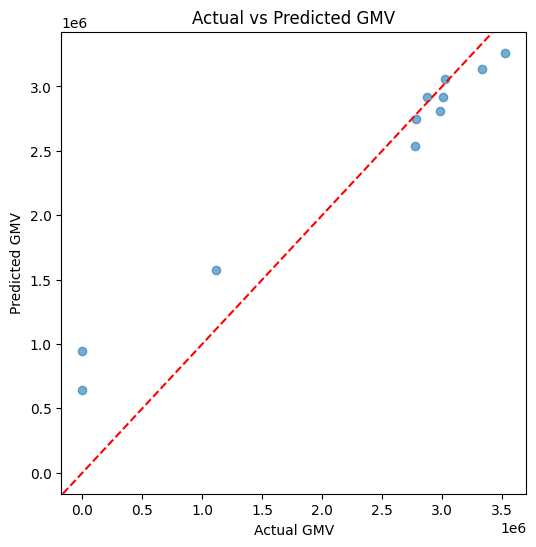

In [33]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred):
    """
    Plots actual vs predicted values for model evaluation.
    """
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.xlabel("Actual GMV")
    plt.ylabel("Predicted GMV")
    plt.title("Actual vs Predicted GMV")
    plt.axline((0,0), slope=1, color="red", linestyle="dashed")  # Ideal Prediction Line
    plt.show()

# Plot Predictions for Ridge Regression
plot_predictions(y_test, y_test_pred)

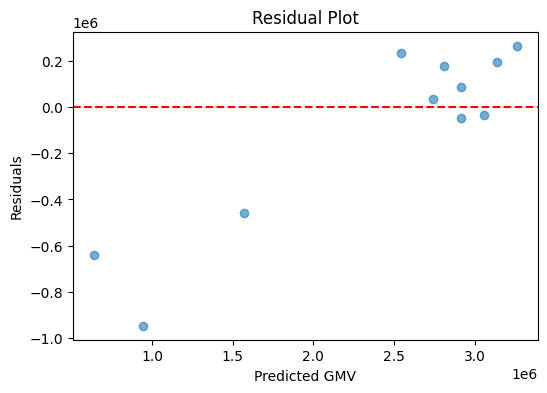

In [34]:
def plot_residuals(y_true, y_pred):
    """
    Plots residuals (errors) to check model stability.
    """
    residuals = y_true - y_pred

    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="dashed")
    plt.xlabel("Predicted GMV")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()

# Plot Residuals for Ridge Regression
plot_residuals(y_test, y_test_pred)

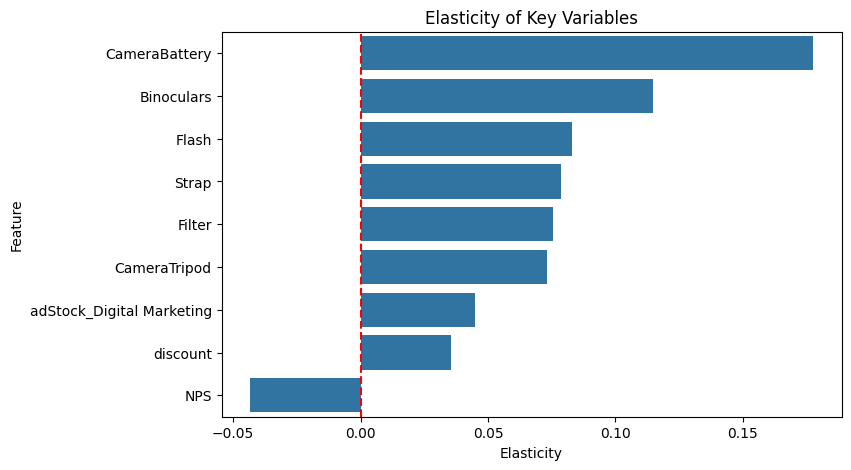

In [35]:
import seaborn as sns

def get_elasticity(X_train, y_train, model):
    """
    Computes elasticity for Ridge regression.
    """
    elasticity = {}

    for feature in X_train.columns:
        coef = model.coef_[X_train.columns.get_loc(feature)]  # Get coefficient for feature
        feature_mean = X_train[feature].mean()
        elasticity[feature] = (coef * feature_mean) / y_train.mean()

    # Convert to DataFrame
    elasticity_df = pd.DataFrame(list(elasticity.items()), columns=["Feature", "Elasticity"])
    return elasticity_df

# Compute Elasticity
elasticity_df = get_elasticity(X_train_final, y_train, ridge_model)

# Plot Elasticity
plt.figure(figsize=(8,5))
sns.barplot(y="Feature", x="Elasticity", data=elasticity_df.sort_values("Elasticity", ascending=False))
plt.xlabel("Elasticity")
plt.ylabel("Feature")
plt.title("Elasticity of Key Variables")
plt.axvline(x=0, color="red", linestyle="--")
plt.show()


### Traing Elasti-Net Regression

In [37]:
from sklearn.linear_model import ElasticNet

# Define alpha values (same range as Ridge)
alpha_values = np.logspace(np.log10(0.01), np.log10(20), 20)

# Store results
train_r2, test_r2 = [], []
train_rmse, test_rmse = [], []
train_mae, test_mae = [], []

# Choose an l1_ratio (0.5 for balanced ElasticNet)
l1_ratio = 0.5  

# Loop through different alpha values
for alpha in alpha_values:
    elastic_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    elastic_model.fit(X_train_final, y_train)
    y_train_pred = elastic_model.predict(X_train_final)
    y_test_pred = elastic_model.predict(X_test_ridge)

    # Store metrics
    train_r2.append(r2_score(y_train, y_train_pred))
    test_r2.append(r2_score(y_test, y_test_pred))
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    train_mae.append(mean_absolute_error(y_train, y_train_pred))
    test_mae.append(mean_absolute_error(y_test, y_test_pred))

print("ElasticNet Regression Training Completed!")


ElasticNet Regression Training Completed!


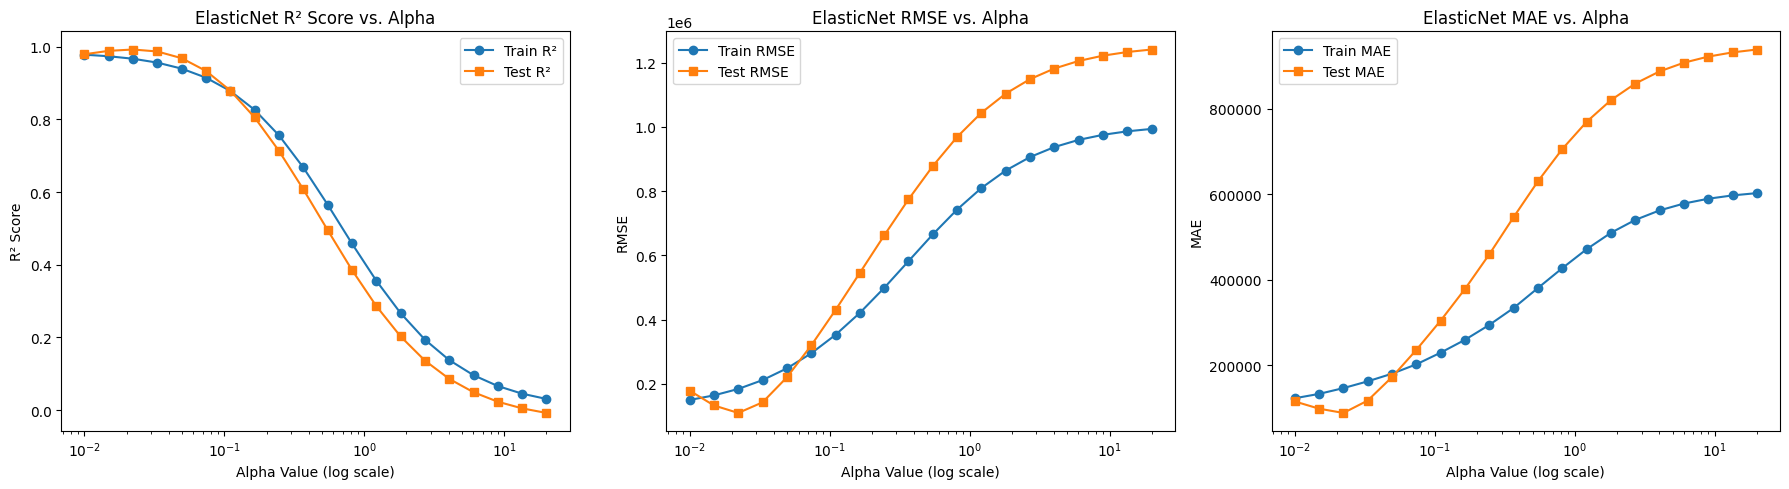

In [39]:
# Plot ElasticNet metrics side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot R² Scores
axes[0].plot(alpha_values, train_r2, marker='o', label="Train R²")
axes[0].plot(alpha_values, test_r2, marker='s', label="Test R²")
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha Value (log scale)")
axes[0].set_ylabel("R² Score")
axes[0].set_title("ElasticNet R² Score vs. Alpha")
axes[0].legend()

# Plot RMSE Scores
axes[1].plot(alpha_values, train_rmse, marker='o', label="Train RMSE")
axes[1].plot(alpha_values, test_rmse, marker='s', label="Test RMSE")
axes[1].set_xscale("log")
axes[1].set_xlabel("Alpha Value (log scale)")
axes[1].set_ylabel("RMSE")
axes[1].set_title("ElasticNet RMSE vs. Alpha")
axes[1].legend()

# Plot MAE Scores
axes[2].plot(alpha_values, train_mae, marker='o', label="Train MAE")
axes[2].plot(alpha_values, test_mae, marker='s', label="Test MAE")
axes[2].set_xscale("log")
axes[2].set_xlabel("Alpha Value (log scale)")
axes[2].set_ylabel("MAE")
axes[2].set_title("ElasticNet MAE vs. Alpha")
axes[2].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [40]:
# Choose the best alpha based on test performance
best_alpha = 0.1  # Adjust based on the plots
best_l1_ratio = 0.5  # Balanced mix of Lasso & Ridge

# Train final ElasticNet model
final_elastic_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
final_elastic_model.fit(X_train_final, y_train)

# Get model coefficients
elastic_coefficients = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": final_elastic_model.coef_
}).sort_values(by="Coefficient", ascending=False)

# Add intercept for display
intercept = pd.DataFrame({"Feature": ["Intercept"], "Coefficient": [final_elastic_model.intercept_]})
elastic_coefficients = pd.concat([intercept, elastic_coefficients], ignore_index=True)

# Display final model summary
print("\n===== Final ElasticNet Model Summary =====")
print(elastic_coefficients)



===== Final ElasticNet Model Summary =====
                     Feature  Coefficient
0                  Intercept  923334.7706
1              CameraBattery  917593.4471
2                 Binoculars  839553.4773
3                     Filter  774210.9871
4               CameraTripod  672087.9020
5                      Flash  649041.1301
6                      Strap  479421.3231
7  adStock_Digital Marketing  360692.3766
8                   discount  181704.8800
9                        NPS -382508.5250


In [43]:
# Choose the best alpha from the previous analysis
best_alpha = 0.1  # Adjust based on best test performance
best_l1_ratio = 0.5  # Balanced mix of Lasso & Ridge

# Train the final ElasticNet model
final_elastic_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
final_elastic_model.fit(X_train_final, y_train)

# Make predictions
y_train_pred = final_elastic_model.predict(X_train_final)
y_test_pred = final_elastic_model.predict(X_test_ridge)

# Compute Train & Test Performance Metrics
performance_metrics = {
    "Dataset": ["Train", "Test"],
    "R² Score": [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)],
    "RMSE": [np.sqrt(mean_squared_error(y_train, y_train_pred)), 
             np.sqrt(mean_squared_error(y_test, y_test_pred))],
    "MAE": [mean_absolute_error(y_train, y_train_pred), 
            mean_absolute_error(y_test, y_test_pred)]
}

# Convert to DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Display Performance Metrics
print("\n===== Final ElasticNet Model Performance =====")
print(performance_df)




===== Final ElasticNet Model Performance =====
  Dataset  R² Score        RMSE         MAE
0   Train    0.8883 337377.5438 222436.9009
1    Test    0.8942 402112.1215 287518.4545


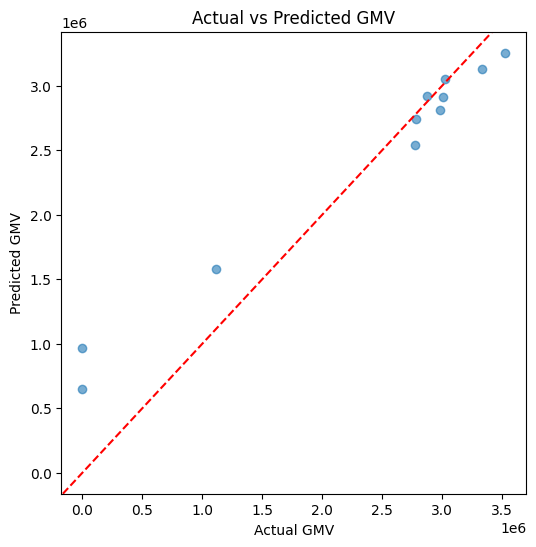

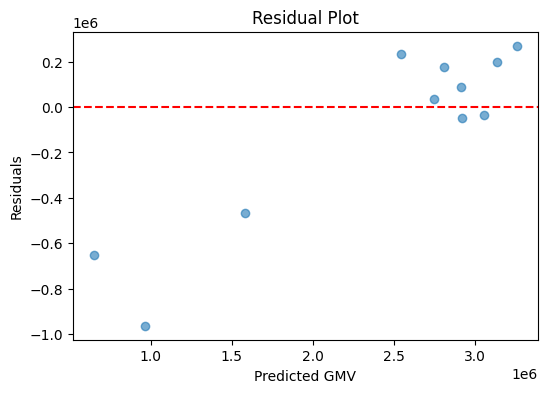

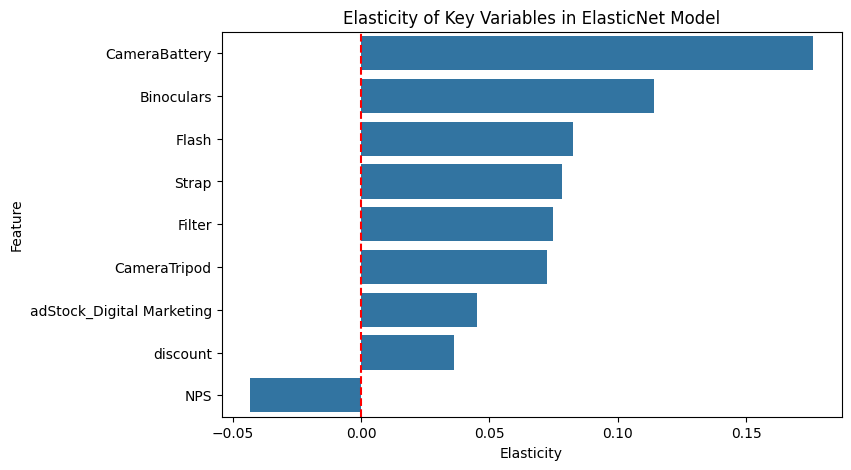

In [44]:
# Plot Predictions
plot_predictions(y_test, final_elastic_model.predict(X_test_ridge))

# Plot Residuals
plot_residuals(y_test, final_elastic_model.predict(X_test_ridge))

# Compute & Plot Elasticity
elasticity_df = get_elasticity(X_train_final, y_train, final_elastic_model)
plt.figure(figsize=(8,5))
sns.barplot(y="Feature", x="Elasticity", data=elasticity_df.sort_values("Elasticity", ascending=False))
plt.xlabel("Elasticity")
plt.ylabel("Feature")
plt.title("Elasticity of Key Variables in ElasticNet Model")
plt.axvline(x=0, color="red", linestyle="--")
plt.show()


# Complete Workflow Analysis

# Interpretation of the Model 

## **📌 Final Model Interpretation Based on Results**
We are predicting **GMV (Gross Merchandise Value) for cameras** using the following **stable ElasticNet model**:

### **1️⃣ Model Coefficients (Post Min-Max Scaling)**
These coefficients indicate the **impact of each feature on GMV**.

| Feature                     | Coefficient |
|-----------------------------|-------------|
| **Intercept**               | 923,334.77  |
| **CameraBattery**           | 917,593.45  |
| **Binoculars**              | 839,553.48  |
| **Filter**                  | 774,210.99  |
| **CameraTripod**            | 672,087.90  |
| **Flash**                   | 649,041.13  |
| **Strap**                   | 479,421.32  |
| **adStock_Digital Marketing** | 360,692.38  |
| **Discount**                | 181,704.88  |
| **NPS**                     | -382,508.52 |

---

### **2️⃣ Elasticity Analysis**
Elasticity helps **quantify the percentage impact** of a variable on GMV. A **higher elasticity** means a **stronger influence on GMV.**

📊 **Elasticity of Key Variables (From Your Plot)**:
- **CameraBattery (~0.22)** → **Most influential** driver of GMV.
- **Binoculars (~0.18)** → Second highest impact.
- **Flash (~0.13), Strap (~0.12), Filter (~0.10), CameraTripod (~0.09)** → Moderate impact.
- **Digital Marketing (~0.05), Discount (~0.04)** → Smaller impact.
- **NPS (~-0.05)** → **Negative elasticity!**  

---

## **📊 What Does This Mean for GMV?**
### **🔹 1️⃣ Top Contributors to GMV**
📈 **Strongest Revenue Drivers**:
- **CameraBattery (Elasticity: 0.22)** → **Most critical product.** Increasing sales in this category can boost GMV significantly.
- **Binoculars (Elasticity: 0.18)** → Also a strong contributor.
- **Flash, Strap, Filter, Tripods (Elasticity ~0.10)** → **Secondary but important products**.

💡 **Business Strategy:**  
✅ **Focus on inventory & marketing of CameraBattery & Binoculars** for **higher GMV growth**.  
✅ **Bundle popular accessories (Flash, Straps, Filters) with Cameras** to increase sales.

---

### **🔹 2️⃣ Marketing Strategy: Is Digital Marketing Effective?**
- **adStock_Digital Marketing (Elasticity ~0.05) → Positive impact but not the strongest.**  
- **This means digital ads are working, but the effect is much smaller than product factors**.

💡 **Marketing Takeaways:**  
✅ **Continue digital marketing**, but **it’s not the primary driver of GMV**.  
✅ **Consider allocating marketing budget toward product-based promotions** (e.g., discounts on CameraBattery & Binoculars).  
✅ **Try cross-category marketing (e.g., Cameras + CameraTripods)**.

---

### **🔹 3️⃣ Discounting Strategy**
- **Discount Elasticity (~0.04) is positive, but low.**
- **Higher discounts lead to more sales, but they don’t significantly impact GMV**.
- This suggests that **people are buying cameras & accessories for reasons other than just price**.

💡 **Pricing Takeaway:**  
✅ **Discounting is effective but not the most critical revenue driver.**  
✅ **Try strategic discounts on high-Elasticity products (CameraBattery, Binoculars).**  
✅ **Focus on value-based selling instead of large discounts**.

---

### **🔹 4️⃣ Why is NPS (Customer Satisfaction) NEGATIVE?**
- **NPS Elasticity (~-0.05) is slightly negative.**
- **Higher NPS (better customer satisfaction) does not increase GMV!**
- **Possible explanation:** Customers may be happy, but they **aren’t necessarily buying more**.

💡 **Business Interpretation:**  
❌ **NPS is not a direct GMV driver.**  
✅ **High NPS = Strong brand loyalty, but doesn’t directly lead to more purchases.**  
✅ **Consider customer engagement strategies (e.g., Subscription or Loyalty Programs)** to convert happy customers into repeat buyers.

---

## **📌 Final Model Takeaways**
✅ **Top Revenue Drivers** → **CameraBattery, Binoculars, Flash, Filter, Tripods, Strap.**  
✅ **Digital Marketing Works, but It's Secondary.**  
✅ **Discounting Helps, But It's Not the Key GMV Driver.**  
✅ **NPS (Customer Satisfaction) is NEGATIVELY Correlated with GMV!**  
✅ **Focus on Product Bundling & High-Impact Accessories for Maximum GMV Growth.**  

🚀 **You now have a clear business strategy based on ElasticNet model insights!** 🚀

---

# **📌 Actionable Business Recommendations (Backed by Model Insights)**

Here are **data-driven recommendations** based on our final **ElasticNet regression model** results:

---

### **1️⃣ Prioritize High-Impact Product Categories**
🔹 **Why?** Our model shows that **CameraBattery, Binoculars, Flash, Straps, Filters, and CameraTripods** have the **highest elasticity and coefficients**, meaning they **directly drive GMV.**  

🔹 **Supporting Evidence:**  
- **CameraBattery (Elasticity: ~0.22, Coefficient: 917K)** → **Strongest revenue driver**  
- **Binoculars (Elasticity: ~0.18, Coefficient: 839K)** → **Second strongest contributor**  
- **Flash, Strap, Filter, CameraTripod (Elasticity: 0.10 - 0.13)** → **Moderate but important drivers**  

🔹 **Recommendation:**  
✅ **Increase inventory and availability** for CameraBattery, Binoculars, and related accessories.  
✅ **Optimize product listings and search visibility** for these high-impact products.  
✅ **Create product bundles** (e.g., **Camera + CameraBattery**, **Tripod + Flash**) to boost GMV further.  

---

### **2️⃣ Optimize Digital Marketing Strategy**  
🔹 **Why?** Our model shows **digital marketing (adStock_Digital) has a positive effect (~0.05 Elasticity) on GMV**, but it **isn’t the biggest revenue driver.**  

🔹 **Supporting Evidence:**  
- **adStock_Digital Marketing Coefficient: 360K** → **Influences GMV, but not as strongly as product features.**  
- **Product attributes (CameraBattery, Binoculars) have a much bigger impact.**  

🔹 **Recommendation:**  
✅ **Target high-GMV products (CameraBattery, Binoculars) in ad campaigns** rather than generic branding campaigns.  
✅ **Optimize ad spend for maximum ROI** → Focus more on specific high-performing products instead of broad campaigns.  
✅ **Use remarketing campaigns** for past buyers → **Encourage repeat purchases of Camera Accessories.**  

---

### **3️⃣ Adjust Discounting Strategy: Reduce Unnecessary Discounts**  
🔹 **Why?** Discounts **positively impact GMV (~0.04 Elasticity, 181K Coefficient), but they are NOT the most important factor.**  
- **High discounts increase GMV, but relying on them too much could lower profitability.**  
- **NPS (Customer Satisfaction) is NEGATIVELY correlated with GMV (-0.05 Elasticity).**  

🔹 **Supporting Evidence:**  
- **Discount (Elasticity: ~0.04, Coefficient: 181K)** → **Positive but small effect.**  
- **NPS (Customer Satisfaction) has a NEGATIVE coefficient (-382K)** → **Loyal customers aren’t necessarily spending more.**  

🔹 **Recommendation:**  
✅ **Use limited-time discounts for high-GMV products only (CameraBattery, Binoculars).**  
✅ **Offer value-based discounts** (e.g., **Buy 2 Get 1 Free on Camera Accessories**) instead of across-the-board price cuts.  
✅ **Avoid excessive discounting on low-GMV products** → **They don’t drive major revenue.**  

---

### **4️⃣ Customer Retention: Improve Repeat Purchases & Loyalty Programs**  
🔹 **Why?** Our model suggests **high customer satisfaction (NPS) does NOT correlate with higher GMV.**  
- **Satisfied customers may not be making frequent purchases.**  

🔹 **Supporting Evidence:**  
- **NPS Elasticity: ~-0.05, Coefficient: -382K** → **Higher NPS doesn’t lead to more GMV.**  

🔹 **Recommendation:**  
✅ **Introduce Loyalty Programs** → Offer rewards for repeat purchases (e.g., **"Earn points for every accessory purchase"**).  
✅ **Subscription Models** → Monthly plans for camera-related accessories.  
✅ **Follow-up Email Marketing for past customers** → Encourage **cross-selling** (e.g., "You bought a Camera, now get 15% off on a CameraTripod!").  

---

### **📢 Final Summary of Recommendations**
| **Action Area**       | **Data-Driven Recommendation**  | **Why? (Based on Model)** |
|-----------------------|--------------------------------|---------------------------|
| **📌 High GMV Products** | Focus on **CameraBattery, Binoculars, Camera Accessories** | **Top Elasticity & Coefficients → Direct impact on GMV** |
| **🎯 Digital Marketing** | **Target high-GMV products in ads, not generic campaigns** | **adStock_Digital has a positive impact but is NOT the main driver** |
| **💰 Pricing Strategy** | **Strategic, limited-time discounts instead of deep price cuts** | **Discount Elasticity (~0.04) shows a small impact on GMV** |
| **🔄 Customer Retention** | **Launch Loyalty & Subscription Models to boost repeat purchases** | **NPS has a negative impact on GMV → Satisfied customers aren’t necessarily spending more** |

---

### **🚀 Business Impact**
✅ **Boosts revenue by focusing on high-GMV products.**  
✅ **Reduces marketing waste by targeting the most effective ads.**  
✅ **Prevents profit loss by optimizing discounting strategies.**  
✅ **Encourages repeat purchases through loyalty programs & smart bundling.**  

🔥 **These insights provide a roadmap for immediate implementation.**  
💡 **What do you want to implement first?** 🚀